In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import gc
import os
import matplotlib.pyplot as plt
import seaborn as sns 
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from tsfresh.feature_extraction import extract_features
np.warnings.filterwarnings('ignore')
import dask.dataframe as dd
import missingno as msno
from pandasql import sqldf
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import KFold
import matplotlib.gridspec as gridspec
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import itertools
import pickle, gzip
import glob

In [2]:
#Always seed the randomness of this universe
np.random.seed(51)

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
%%time
train_metadata_kaggle = dd.read_csv('mydata_train_metadata.csv')
test_metadata_kaggle = dd.read_csv('mydata_test_metadata.csv')
train_metadata_kaggle = train_metadata_kaggle.compute()
test_metadata_kaggle = test_metadata_kaggle.compute()
print(train_metadata_kaggle.shape,test_metadata_kaggle.shape)

(7848, 142) (3492890, 141)
CPU times: user 3min 25s, sys: 12.6 s, total: 3min 37s
Wall time: 41.4 s


In [5]:
%%time
train_metadata1 = dd.read_csv('train_metadata_final.csv')
test_metadata1 = dd.read_csv('test_metadata_final.csv')
train_metadata1 = train_metadata1.compute()
test_metadata1 = test_metadata1.compute()
print(train_metadata1.shape,test_metadata1.shape)

(7848, 233) (3492890, 232)
CPU times: user 3min 37s, sys: 12.8 s, total: 3min 50s
Wall time: 42.4 s


In [6]:
def reduce_mem_usage(df):

    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [7]:
train_metadata_kaggle = train_metadata_kaggle.merge(train_metadata1[['object_id'] + [x for x in train_metadata1.columns if x not in train_metadata_kaggle.columns] ],how = 'left',on = 'object_id')

In [8]:
%%time
test_metadata1 = reduce_mem_usage(test_metadata1)
test_metadata_kaggle = test_metadata_kaggle.merge(test_metadata1[['object_id'] + [x for x in test_metadata1.columns if x not in test_metadata_kaggle.columns] ],how = 'left',on = 'object_id')

Memory usage of dataframe is 6209.13 MB
Memory usage after optimization is: 1935.36 MB
Decreased by 68.8%
CPU times: user 3min 5s, sys: 3min 56s, total: 7min 2s
Wall time: 7min 2s


In [9]:
print(train_metadata_kaggle.shape,test_metadata_kaggle.shape)

(7848, 358) (3492890, 357)


In [10]:
train_metadata_kaggle.head()

,object_id,flux_min,flux_max,flux_mean,flux_median,flux_std,flux_skew,flux_err_min,flux_err_max,flux_err_mean,flux_err_median,flux_err_std,flux_err_skew,detected_mean,flux_ratio_sq_sum,flux_ratio_sq_skew,flux_by_flux_ratio_sq_sum,flux_by_flux_ratio_sq_skew,flux_w_mean,flux_diff1,flux_diff2,flux_diff3,"0__fft_coefficient__coeff_0__attr_""abs""","0__fft_coefficient__coeff_1__attr_""abs""",0__kurtosis,0__skewness,"1__fft_coefficient__coeff_0__attr_""abs""","1__fft_coefficient__coeff_1__attr_""abs""",1__kurtosis,1__skewness,"2__fft_coefficient__coeff_0__attr_""abs""","2__fft_coefficient__coeff_1__attr_""abs""",2__kurtosis,2__skewness,"3__fft_coefficient__coeff_0__attr_""abs""","3__fft_coefficient__coeff_1__attr_""abs""",3__kurtosis,3__skewness,"4__fft_coefficient__coeff_0__attr_""abs""","4__fft_coefficient__coeff_1__attr_""abs""",4__kurtosis,4__skewness,"5__fft_coefficient__coeff_0__attr_""abs""","5__fft_coefficient__coeff_1__attr_""abs""",5__kurtosis,5__skewness,flux__length,flux__longest_strike_above_mean,flux__longest_strike_below_mean,flux__mean_abs_change,flux__mean_change,flux_by_flux_ratio_sq__longest_strike_above_mean,flux_by_flux_ratio_sq__longest_strike_below_mean,mjd__mean_abs_change,mjd__mean_change,mjd_diff_det,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,haversine,latlon1,hostgal_photoz_certain,A0_sum_flux,A0_mean_flux,A0_std_detected,A1_mean_detected,A2_sum_detected,A4_mean_detected,A5_std_detected,A5_mean_detected,percent_p2_region_minus_1,A2_min_flux,A5_sum_detected,__flux_percentile_ratio_mid50___5_,__flux_percentile_ratio_mid65___2_,__median_absolute_deviation___2_,__qso_log_chi2_qsonu___0_,__stetson_k___1_,__freq1_signif___2_,__stetson_k___2_,__freq3_amplitude1___1_,__median_absolute_deviation___2_.1,__percent_close_to_median___2_,__freq_varrat___5_,__freq_varrat___4_,__qso_log_chi2_qsonu___3_,__qso_log_chi2_qsonu___1_,__qso_log_chi2_qsonu___5_,__std___4_,__freq_varrat___3_,__amplitude___2_,outlierScore,hipd,lipd,highEnergy_transitory_1.0_TF,highEnergy_transitory_1.5_TF,lowEnergy_transitory_1.0_TF,lowEnergy_transitory_1.5_TF,A1_minus_3_sigma,A5_max_median_diff_flux,A5_minus_3_sigma,A5_max_mean_diff_flux,diff_A5_A4_max_min_flux,diff_A2_A1_max_min_flux,diff_A3_A2_median_min_flux,diff_A5_A4_max_median_flux,diff_A4_A3_max_median_flux,diff_A2_A0_median_min_flux,diff_A4_A3_max_mean_flux,diff_A5_A2_max_mean_flux,diff_A5_A3_max_mean_flux,diff_A4_A0_median_mean_flux,diff_A5_A4_max_mean_flux,diff_A2_A1_max_median_flux,diff_A5_A2_max_median_flux,diff_A5_A4_median_min_flux,diff_A4_A0_median_min_flux,diff_A4_A1_max_median_flux,diff_A4_A2_max_median_flux,diff_A5_A4_minus_1_sigma,diff_A5_A3_median_min_flux,diff_A5_A3_max_median_flux,diff_A3_A1_minus_1_sigma,diff_A3_A0_median_min_flux,diff_A3_A0_plus_1_sigma,diff_A1_A0_median_min_flux,diff_A4_A2_mean_min_flux,diff_A5_A1_plus_1_sigma,diff_A4_A1_median_mean_flux,diff_A3_A2_max_median_flux,diff_A5_A1_median_mean_flux,div_A4_A2_median_min_flux,div_A5_A2_median_min_flux,div_A5_A2_minus_1_sigma,div_A5_A4_median_mean_flux,div_A3_A0_plus_1_sigma,div_A4_A1_minus_1_sigma,A5_median_mean_avg_flux,A4_mean_min_avg_flux,A0_max_mean_avg_flux,ra,decl,gal_l,gal_b,ddf,hostgal_specz,NG_min_flux_err,NG_max_flux_err,NG_std_flux_err,NG_sum_flux_err,NG_mean_flux_err,NG_median_flux_err,NG_min_flux,NG_max_flux,NG_std_flux,NG_sum_flux,NG_mean_flux,NG_median_flux,NG_count_detected,NG_std_detected,NG_sum_detected,NG_mean_detected,NG_median_detected,A0_min_flux_err,A0_max_flux_err,A0_std_flux_err,A0_sum_flux_err,A0_mean_flux_err,A0_median_flux_err,A0_min_flux,A0_max_flux,A0_std_flux,A0_median_flux,A0_count_detected,A0_sum_detected,A0_mean_detected,A0_median_detected,A1_min_flux_err,A1_max_flux_err,A1_std_flux_err,A1_sum_flux_err,A1_mean_flux_err,A1_median_flux_err,A1_min_flux,A1_max_flux,A1_std_flux,A1_sum_flux,A1_mean_flux,A1_median_flux,A1_count_detected,A1_std_detected,A1_sum_detected,A1_median_detected,A2_min_flux_err,A2_max_flux_err,A2_std_flux_err,A2_sum_flux_err,A2_mean_flux_err,A2_median_

In [11]:
"""%%time
f2_train = dd.read_csv('myfeatures_train_embeddings.csv')
f2_test = dd.read_csv('myfeatures_test_embeddings.csv')
f2_train = f2_train.compute()
f2_test = f2_test.compute()
print(f2_train.shape,f2_test.shape)"""

"%%time\nf2_train = dd.read_csv('myfeatures_train_embeddings.csv')\nf2_test = dd.read_csv('myfeatures_test_embeddings.csv')\nf2_train = f2_train.compute()\nf2_test = f2_test.compute()\nprint(f2_train.shape,f2_test.shape)"

In [12]:
"""%%time
train_metadata_kaggle = train_metadata_kaggle.merge(f2_train,how='left',on = 'object_id')
test_metadata_kaggle = test_metadata_kaggle.merge(f2_test,how='left',on = 'object_id')
print(train_metadata_kaggle.shape,test_metadata_kaggle.shape)"""

"%%time\ntrain_metadata_kaggle = train_metadata_kaggle.merge(f2_train,how='left',on = 'object_id')\ntest_metadata_kaggle = test_metadata_kaggle.merge(f2_test,how='left',on = 'object_id')\nprint(train_metadata_kaggle.shape,test_metadata_kaggle.shape)"

In [13]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score

In [14]:
temp = train_metadata_kaggle.copy()

In [15]:
y = temp['target']

In [16]:
del temp['target']

In [17]:
classes = sorted(y.unique())

# Taken from Giba's topic : https://www.kaggle.com/titericz
# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
# with Kyle Boone's post https://www.kaggle.com/kyleboone
class_weight = {
    c: 1 for c in classes
}
for c in [64, 15]:
    class_weight[c] = 2

print('Unique classes : ', classes)

train_id = temp['object_id']
del temp['object_id']

Unique classes :  [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]


In [18]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=51)

In [19]:
temp.fillna(0.0, inplace=True)

In [20]:
%%time
for i in temp.columns:
    #print(i)
    temp[i].replace(np.inf, 0.0, inplace=True)
    temp[i].replace(-np.inf, 0.0, inplace=True)

CPU times: user 399 ms, sys: 694 µs, total: 400 ms
Wall time: 397 ms


In [21]:
ss = StandardScaler()
full_train_ss = ss.fit_transform(temp)

In [22]:
test_id = test_metadata_kaggle['object_id']

In [23]:
from keras.models import Sequential
from keras.layers import Dense,BatchNormalization,Dropout
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from keras.utils import to_categorical
from keras import backend as K
import keras
from keras import regularizers
from collections import Counter
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [24]:
from keras.optimizers import Adam, RMSprop

In [25]:
# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/69795
def mywloss(y_true,y_pred):  
    yc=tf.clip_by_value(y_pred,1e-15,1-1e-15)
    loss=-(tf.reduce_mean(tf.reduce_mean(y_true*tf.log(yc),axis=0)/wtable))
    return loss

In [26]:
def multi_weighted_logloss(y_ohe, y_p):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1-1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set 
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos    
    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss

In [27]:
from keras.layers import PReLU, ReLU, Activation

In [28]:
K.clear_session()
tf.reset_default_graph()

In [29]:
unique_y = np.unique(y)
class_map = dict()
for i,val in enumerate(unique_y):
    class_map[val] = i
        
y_map = np.zeros((y.shape[0],))
y_map = np.array([class_map[val] for val in y])
y_categorical = to_categorical(y_map)

In [30]:
y_count = Counter(y_map)
wtable = np.zeros((len(unique_y),))
for i in range(len(unique_y)):
    wtable[i] = y_count[i]/y_map.shape[0]

In [31]:
def plot_loss_acc(history):
    plt.plot(history.history['loss'][1:])
    plt.plot(history.history['val_loss'][1:])
    plt.title('model loss')
    plt.ylabel('val_loss')
    plt.xlabel('epoch')
    plt.legend(['train','Validation'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['acc'][1:])
    plt.plot(history.history['val_acc'][1:])
    plt.title('model Accuracy')
    plt.ylabel('val_acc')
    plt.xlabel('epoch')
    plt.legend(['train','Validation'], loc='upper left')
    plt.show()

In [32]:
def build_model(dropout_rate=0.25, activation='relu'):
    start_neurons = 256
    # create model
    model = Sequential()
    
    model.add(Dense(start_neurons, input_dim=full_train_ss.shape[1], activation=None))
    model.add(BatchNormalization())
    model.add(Activation('sigmoid'))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//2,activation=None))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//4,activation=None))
    model.add(BatchNormalization())
    model.add(Activation('sigmoid'))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(len(classes), activation='softmax'))
    
    return model

fold_0 started


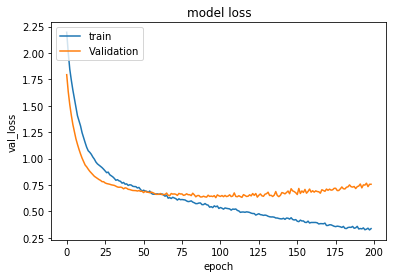

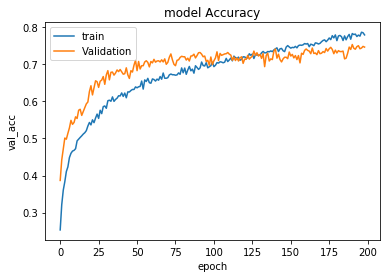

Loading Best Model
0.6279768150307409
fold_1 started


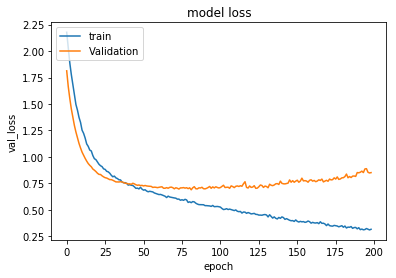

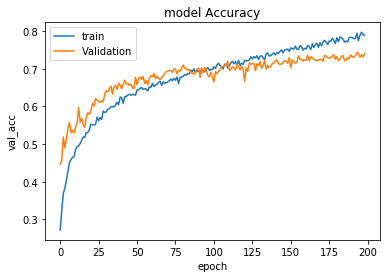

Loading Best Model
0.6926983561022658
fold_2 started


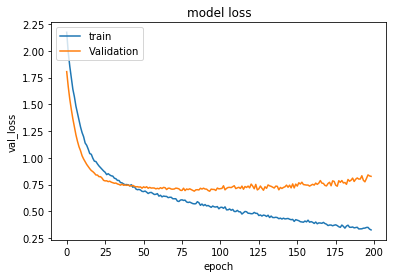

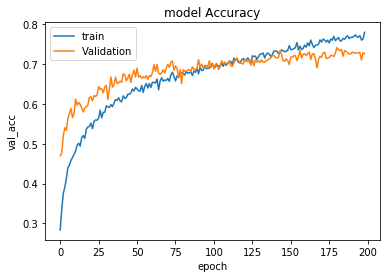

Loading Best Model
0.676112268194109
fold_3 started


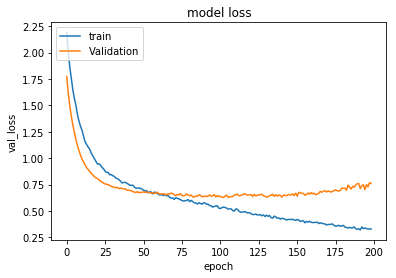

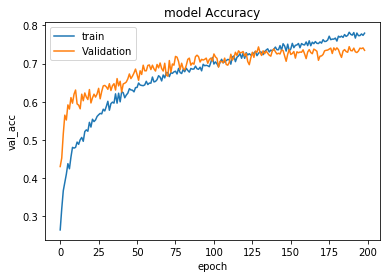

Loading Best Model
0.622842616678974
fold_4 started


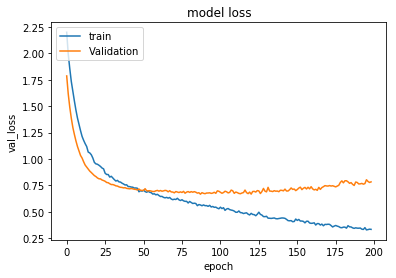

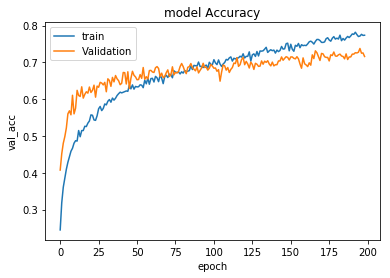

Loading Best Model
0.6677102565679175
MULTI WEIGHTED LOG LOSS : 0.65753 
CPU times: user 4min 48s, sys: 37 s, total: 5min 25s
Wall time: 2min 49s


In [33]:
%%time
clfs = []
oof_preds = np.zeros((len(full_train_ss), len(classes)))
epochs = 200
batch_size = 256

for fold_, (trn_, val_) in enumerate(folds.split(y_map, y_map)):
    checkPoint = ModelCheckpoint("./keras.model",monitor='val_loss',mode = 'min', save_best_only=True, verbose=0)
    x_train, y_train = full_train_ss[trn_], y_categorical[trn_]
    x_valid, y_valid = full_train_ss[val_], y_categorical[val_]
    
    #trn_xa, trn_y, val_xa, val_y=smoteAdataset(x_train, y_train, x_valid, y_valid)
    #x_train=pd.DataFrame(data=trn_xa, columns=x_train.columns)
    #x_valid=pd.DataFrame(data=val_xa, columns=x_valid.columns)
    print("fold_{} started".format(fold_))
    
    K.clear_session()
    model = build_model(dropout_rate=0.30, activation='sigmoid')
    adam = Adam(lr = 0.0009)
    model.compile(loss=mywloss, optimizer=adam, metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,shuffle=True,verbose=0,callbacks=[checkPoint])       
    
    plot_loss_acc(history)
    
    print('Loading Best Model')
    model.load_weights('./keras.model')
    # # Get predicted probabilities for each class
    oof_preds[val_, :] = model.predict_proba(x_valid,batch_size=batch_size)
    print(multi_weighted_logloss(y_valid, model.predict_proba(x_valid,batch_size=batch_size)))
    clfs.append(model)
    
print('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_categorical,oof_preds))

In [34]:
del train_metadata1,test_metadata1
gc.collect()

22261

In [35]:
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [36]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_map, np.argmax(oof_preds,axis=-1))
np.set_printoptions(precision=2)

In [37]:
sample_sub = pd.read_csv('sample_submission.csv')
class_names = list(sample_sub.columns[1:-1])
#del sample_sub;gc.collect()

Normalized confusion matrix
[[9.27e-01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 6.62e-03 0.00e+00 0.00e+00
  5.30e-02 6.62e-03 0.00e+00 6.62e-03 0.00e+00 0.00e+00]
 [0.00e+00 7.66e-01 0.00e+00 3.64e-02 2.42e-02 0.00e+00 5.05e-02 1.62e-02
  0.00e+00 4.04e-02 4.04e-03 5.05e-02 0.00e+00 1.21e-02]
 [3.25e-03 0.00e+00 9.82e-01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  6.49e-03 0.00e+00 1.08e-03 0.00e+00 7.58e-03 0.00e+00]
 [8.38e-04 1.08e-01 0.00e+00 2.73e-01 1.19e-01 0.00e+00 2.10e-01 3.69e-02
  0.00e+00 8.30e-02 8.38e-04 1.48e-01 8.38e-04 1.84e-02]
 [0.00e+00 5.46e-02 0.00e+00 1.04e-01 3.72e-01 0.00e+00 1.09e-01 5.46e-03
  0.00e+00 1.26e-01 0.00e+00 2.30e-01 0.00e+00 0.00e+00]
 [3.33e-02 0.00e+00 0.00e+00 0.00e+00 0.00e+00 9.67e-01 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 3.51e-02 0.00e+00 1.01e-01 9.09e-02 0.00e+00 4.46e-01 9.09e-02
  0.00e+00 1.78e-01 0.00e+00 5.37e-02 0.00e+00 4.13e-03]
 [0.00e+00 2.94e-02 0.00e+00 0.00e+00 9.80e-03 0.00e+00

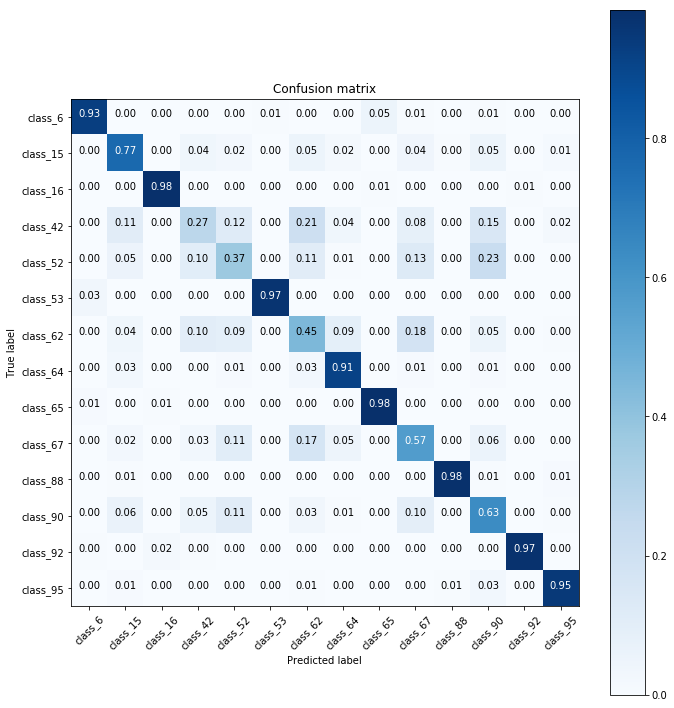

In [38]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
foo = plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Confusion matrix')

In [39]:
print(len(clfs))

5


In [40]:
oof_preds2 = pd.DataFrame(pd.concat([train_id,pd.DataFrame(oof_preds,columns=list(sample_sub.columns[1:-1] ) ) ],axis=1) )

In [41]:
oof_preds2.tail()

,object_id,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95
7843,130739978,0.000564,0.000248,0.000355,0.000293,0.000033,0.000022,0.000040,0.000040,0.998163,0.000004,0.000006,0.000066,0.000156,0.000010
7844,130755807,0.000022,0.880469,0.000054,0.084741,0.006084,0.000098,0.009450,0.000397,0.000115,0.001351,0.000222,0.016295,0.000055,0.000649
7845,130762946,0.000132,0.000022,0.999065,0.000181,0.000069,0.000013,0.000052,0.000028,0.000255,0.000011,0.000044,0.000013,0.000112,0.000003
7846,130772921,0.001653,0.671405,0.003425,0.103712,0.000928,0.000431,0.057271,0.025452,0.079344,0.016866,0.004080,0.026146,0.001822,0.007466
7847,130779836,0.372690,0.000201,0.054016,0.082621,0.061799,0.000662,0.229108,0.003280,0.009557,0.138992,0.000028,0.019861,0.027150,0.000035


In [42]:
print(oof_preds2.shape)

(7848, 15)


In [43]:
oof_preds2.to_csv('oof_preds_mlp.csv',index=False)

In [44]:
del oof_preds2
gc.collect()

10736

In [45]:
%%time
temp_test = test_metadata_kaggle.copy()

CPU times: user 3.36 s, sys: 4.99 s, total: 8.35 s
Wall time: 8.35 s


In [46]:
gc.enable()
del train_metadata_kaggle,test_metadata_kaggle
gc.collect()

7

In [47]:
temp_test = reduce_mem_usage(temp_test)

Memory usage of dataframe is 5559.57 MB
Memory usage after optimization is: 3201.17 MB
Decreased by 42.4%


In [48]:
del temp_test['object_id']

In [49]:
list(temp.columns) == list(temp_test.columns)

True

In [50]:
temp_test.fillna(0, inplace=True)

In [51]:
%%time
for i in temp_test.columns:
    #print(i)
    temp_test[i].replace(np.inf, 0, inplace=True)
    temp_test[i].replace(-np.inf, 0, inplace=True)

CPU times: user 20.4 s, sys: 12 ms, total: 20.4 s
Wall time: 20.4 s


In [52]:
temp_test = ss.transform(temp_test)

In [53]:
%%time
test_pred0 = pd.DataFrame()
test_pred1 = pd.DataFrame()
test_pred2 = pd.DataFrame()
test_pred3 = pd.DataFrame()
test_pred4 = pd.DataFrame()

list_of_df = [test_pred0,test_pred1,test_pred2,test_pred3,test_pred4]

for num,c in enumerate(clfs):
    print(num)
    for k in range(0,len(temp_test),500000):
        test_pred = pd.DataFrame(c.predict_proba(temp_test[ k:k+500000] ))
        list_of_df[num] = pd.concat([list_of_df[num],test_pred],axis=0)
        del test_pred

0
1
2
3
4
CPU times: user 13min 50s, sys: 1min 55s, total: 15min 46s
Wall time: 8min 11s


In [54]:
test_pred2 = pd.DataFrame()
test_pred2 = (list_of_df[0] + list_of_df[1] + list_of_df[2] + list_of_df[3] + list_of_df[4])/5

In [55]:
print(test_pred2.shape)

(3492890, 14)


In [56]:
#test_pred2 = pd.DataFrame(np.random.rand(10,14))

In [57]:
test_pred2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.000908,0.005116,0.000177,0.709102,0.033703,0.000082,0.231950,0.000277,0.000093,0.002988,0.000001,0.015199,0.000069,3.356425e-04
1,0.000179,0.025597,0.001130,0.161476,0.338479,0.000225,0.191031,0.157301,0.034550,0.053437,0.000051,0.035862,0.000682,3.702254e-07
2,0.000042,0.034564,0.000227,0.203769,0.287064,0.000162,0.168403,0.062465,0.003415,0.136719,0.000014,0.102953,0.000199,4.660552e-06
3,0.000187,0.002384,0.000138,0.048643,0.031878,0.000032,0.283491,0.026395,0.000049,0.585008,0.000002,0.021426,0.000358,8.878480e-06
4,0.000009,0.004027,0.000037,0.050674,0.144243,0.000043,0.009907,0.000012,0.000042,0.038536,0.000242,0.751540,0.000023,6.654120e-04


In [58]:
temp_columns = ['object_id','class_6','class_15','class_16','class_42','class_52','class_53','class_62','class_64','class_65','class_67','class_88','class_90','class_92','class_95','class_99']

In [59]:
test_pred2.columns = temp_columns[1:15]

In [60]:
def getUnknown(data):
    return ((((((data["mymedian"]) + (((data["mymean"]) / 2.0)))/2.0)) + (((((1.0) - (((data["mymax"]) * (((data["mymax"]) * (data["mymax"]))))))) / 2.0)))/2.0)

feats = ['class_6', 'class_15', 'class_16', 'class_42', 'class_52', 'class_53',
         'class_62', 'class_64', 'class_65', 'class_67', 'class_88', 'class_90',
         'class_92', 'class_95']

In [61]:
klm = pd.DataFrame()
klm['mymean'] = test_pred2[feats].mean(axis=1)
klm['mymedian'] = test_pred2[feats].median(axis=1)
klm['mymax'] = test_pred2[feats].max(axis=1)

In [62]:
test_pred2['class_99'] = getUnknown(klm)

In [63]:
test_pred2.tail()

,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
492885,0.000066,0.432845,0.000298,0.177892,0.060497,0.000180,0.138755,0.130106,0.003393,0.028931,0.000029,0.026713,0.000290,3.956707e-06,0.242418
492886,0.000043,0.005805,0.000151,0.016970,0.007674,0.000040,0.043266,0.900273,0.000448,0.021634,0.000002,0.003097,0.000596,2.689457e-07,0.076974
492887,0.001459,0.011756,0.000189,0.530778,0.088934,0.000069,0.333598,0.000449,0.000031,0.011012,0.000003,0.021198,0.000071,4.495423e-04,0.221784
492888,0.000021,0.114408,0.000580,0.054310,0.008148,0.000184,0.023762,0.786194,0.001634,0.004556,0.000011,0.005697,0.000494,2.993187e-06,0.138216
492889,0.000052,0.258609,0.000211,0.252207,0.097430,0.000066,0.099528,0.176858,0.010963,0.033184,0.000121,0.070017,0.000749,5.822266e-06,0.260123


In [64]:
test_pred2 = test_pred2.reset_index(drop=True)

In [65]:
print(test_pred2.shape,test_id.shape)

(3492890, 15) (3492890,)


In [66]:
test_id.tail()

3492885    130787966
3492886    130787971
3492887    130787974
3492888    130788053
3492889    130788054
Name: object_id, dtype: int64

In [67]:
test_id = test_id.reset_index(drop=True)

In [68]:
test_id.index == test_pred2.index

array([ True,  True,  True, ...,  True,  True,  True])

In [69]:
%%time
test_pred = pd.concat([test_id,test_pred2],axis=1)

CPU times: user 50.8 ms, sys: 89.3 ms, total: 140 ms
Wall time: 138 ms


In [70]:
test_pred = test_pred[temp_columns]

In [71]:
test_pred.head()

,object_id,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
0,13,0.000908,0.005116,0.000177,0.709102,0.033703,0.000082,0.231950,0.000277,0.000093,0.002988,0.000001,0.015199,0.000069,3.356425e-04,0.169946
1,14,0.000179,0.025597,0.001130,0.161476,0.338479,0.000225,0.191031,0.157301,0.034550,0.053437,0.000051,0.035862,0.000682,3.702254e-07,0.256752
2,17,0.000042,0.034564,0.000227,0.203769,0.287064,0.000162,0.168403,0.062465,0.003415,0.136719,0.000014,0.102953,0.000199,4.660552e-06,0.257762
3,23,0.000187,0.002384,0.000138,0.048643,0.031878,0.000032,0.283491,0.026395,0.000049,0.585008,0.000002,0.021426,0.000358,8.878480e-06,0.209219
4,34,0.000009,0.004027,0.000037,0.050674,0.144243,0.000043,0.009907,0.000012,0.000042,0.038536,0.000242,0.751540,0.000023,6.654120e-04,0.152922


In [72]:
print(test_pred.shape)

(3492890, 16)


In [73]:
%%time
test_pred.to_csv('test_pred_45.csv',index=False)

CPU times: user 1min 2s, sys: 2.6 ms, total: 1min 2s
Wall time: 1min 2s


In [ ]:
#!kaggle competitions submit -c PLAsTiCC-2018 -f test_pred_21.csv -m "Message"